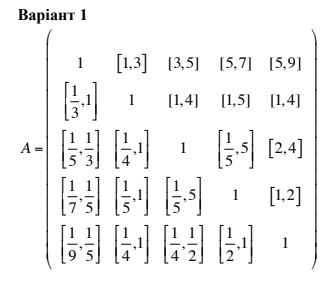

In [45]:
from scipy.stats import gmean
from scipy.optimize import minimize
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [13]:
values = np.array([
    [np.array([1]),        np.array([1, 3]),   np.array([3, 5]),     np.array([5, 7]),   np.array([5, 9])],
    [np.array([1/3, 1]),   np.array([1]),      np.array([1, 4]),     np.array([1, 5]),   np.array([1, 4])],
    [np.array([1/5, 1/3]), np.array([1/4, 1]), np.array([1]),        np.array([1/5, 5]), np.array([2, 4])],
    [np.array([1/7, 1/5]), np.array([1/5, 1]), np.array([1/5, 5]),   np.array([1]),      np.array([1, 2])],
    [np.array([1/9, 1/5]), np.array([1/4, 1]), np.array([1/4, 1/2]), np.array([1/2, 1]), np.array([1])]
])

data_fuzzy = pd.DataFrame(values)
ds = pd.DataFrame(np.ones(values.shape) * 0.5)

<ipython-input-13-cba2dbf0491b>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([


In [31]:
data_fuzzy

,0,1,2,3,4
0,[1],"[1, 3]","[3, 5]","[5, 7]","[5, 9]"
1,"[0.3333333333333333, 1.0]",[1],"[1, 4]","[1, 5]","[1, 4]"
2,"[0.2, 0.3333333333333333]","[0.25, 1.0]",[1],"[0.2, 5.0]","[2, 4]"
3,"[0.14285714285714285, 0.2]","[0.2, 1.0]","[0.2, 5.0]",[1],"[1, 2]"
4,"[0.1111111111111111, 0.2]","[0.25, 1.0]","[0.25, 0.5]","[0.5, 1.0]",[1]


In [104]:
def TLGP(data_fuzzy):
    n = data_fuzzy.shape[1]

    # X0 = [x,y,p,q]
    # starting points x,y,p,q

    x0 = [0.15 for i in range(n)]  # 5 штук
    y0 = [0.15 for i in range(n)]  # 5 штук
    p0 = [0.15 for i in range(n) for j in range(n) if i < j]  # 10 штук
    q0 = [0.15 for i in range(n) for j in range(n) if i < j]  # 10 штук

    view = {
        "x": list(range(n)),
        "y": list(range(n, 2 * n)),
        "p": list(range(2 * n, 2 * n + len(p0))),
        "q": list(range(2 * n + len(p0), 2 * n + 2 * len(p0))),
    }

    map_idx = {
        (i, j): k
        for k, (i, j) in enumerate((i, j) for i in range(n) for j in range(n) if i < j)
    }

    X = np.array(x0 + y0 + p0 + q0)
    
    def x_constraint(X, i):  # (InEq) for i in range(n)
        x, y, p, q = X[view["x"]], X[view["y"]], X[view["p"]], X[view["q"]]
        return x[i]
    
    def y_constraint(X, i):  # (InEq) for i in range(n)
        x, y, p, q = X[view["x"]], X[view["y"]], X[view["p"]], X[view["q"]]
        return y[i]

    def xy_constraint(X, i):  # (Eq) for i in range(n)
        x, y, p, q = X[view["x"]], X[view["y"]], X[view["p"]], X[view["q"]]
        return x[i] * y[i]

    def p_constraint(X, i, j):  # (Ineq) forall i<j
        x, y, p, q = X[view["x"]], X[view["y"]], X[view["p"]], X[view["q"]]
        return p[map_idx[(i, j)]]

    def q_constraint(X, i, j):  # (Ineq) forall i<j
        x, y, p, q = X[view["x"]], X[view["y"]], X[view["p"]], X[view["q"]]
        return q[map_idx[(i, j)]]

    def pq_constraint(X, i, j):  # (Eq) forall i<j
        x, y, p, q = X[view["x"]], X[view["y"]], X[view["p"]], X[view["q"]]
        return p[map_idx[(i, j)]] * q[map_idx[(i, j)]]

    def sum_constraint(X):  # (Eq)
        x, y, p, q = X[view["x"]], X[view["y"]], X[view["p"]], X[view["q"]]
        return np.sum(x - y)

    def l_constraint(X, i, j):  # (Ineq) i<j
        x, y, p, q = X[view["x"]], X[view["y"]], X[view["p"]], X[view["q"]]
        con = (
            x[i]
            - y[i]
            - x[j]
            + y[j]
            + p[map_idx[(i, j)]]
            - np.log(data_fuzzy.iloc[i, j])[0]
        )
        return con

    def u_constraint(X, i, j):  # (Ineq) i<j
        x, y, p, q = X[view["x"]], X[view["y"]], X[view["p"]], X[view["q"]]
        con = (
            x[i]
            - y[i]
            - x[j]
            + y[j]
            - q[map_idx[(i, j)]]
            - np.log(data_fuzzy.iloc[i, j])[1]
        )
        return -con
    
    # x,y constraints:
    cons = [{'type': 'ineq', 'fun': x_constraint, 'args': (i, )} for i in range(n)] # n times x>=0
    cons += [{'type': 'ineq', 'fun': y_constraint, 'args': (i, )} for i in range(n)] # n times y>=0
    cons += [{'type': 'eq', 'fun': xy_constraint, 'args': (i, )} for i in range(n)] # n times x*y==0
    cons += [{'type': 'eq', 'fun': sum_constraint}] # Sum 0:(n-1){(xi-yi)}==0
    
    #p,q constraints:
    cons += [{'type': 'ineq', 'fun': p_constraint, 'args': (i,j)} for i in range(n) for j in range(n) if i<j] # p_ij>=0 forall i<j
    cons += [{'type': 'ineq', 'fun': q_constraint, 'args': (i,j)} for i in range(n) for j in range(n) if i<j] # q_ij>=0 forall i<j
    cons += [{'type': 'eq', 'fun': pq_constraint, 'args': (i,j)} for i in range(n) for j in range(n) if i<j] # p_ij*q_ij==0 forall i<j
    
    # data constraints:
    cons += [{'type': 'ineq', 'fun': l_constraint, 'args': (i,j)} for i in range(n) for j in range(n) if i<j] # >=log(l_ij) forall i<j
    cons += [{'type': 'ineq', 'fun': u_constraint, 'args': (i,j)} for i in range(n) for j in range(n) if i<j] # <= log(u_ij) forall i<j
    
    def obj(X):
        x, y, p, q = X[view["x"]], X[view["y"]], X[view["p"]], X[view["q"]]
        res = sum([p[map_idx[(i, j)]] + q[map_idx[(i, j)]] for i in range(n) for j in range(n) if i<j])
        return res
    
    J_star=0
    res = minimize(obj, X, constraints = cons)
    print("Stage 1 success:\n", res["success"], "\n\nJ*:", res["fun"]) 
    J_star = res["fun"]
    X = res["x"]
    
    #STAGE 2
    
    def stage2_constraint(X):
        return obj(X)-J_star
    
    def obj_stage2_min(X, i):
        x, y, p, q = X[view["x"]], X[view["y"]], X[view["p"]], X[view["q"]]
        return x[i]-y[i]
    
    def obj_stage2_max(X, i):
        x, y, p, q = X[view["x"]], X[view["y"]], X[view["p"]], X[view["q"]]
        return -(x[i]-y[i])
    
    cons += [{'type': 'eq', 'fun': stage2_constraint}] #sum sum (p+q) == J*
    
    ln_w_l = []
    ln_w_u = []
    for i in range(n):
        res = minimize(obj_stage2_min, X, args = (i,) ,constraints = cons)
        ln_w_l.append(res["fun"])
        res = minimize(obj_stage2_max, X, args = (i,) ,constraints = cons)
        ln_w_u.append(res["fun"])
        
    return np.vstack([np.exp(np.array(ln_w_l)), np.exp(np.array(ln_w_u))]).T
        


TLGP(data_fuzzy)


Stage 1 success:
 True 

J*: 2.4826771760526407


array([[2.44062129, 0.        ],
       [1.        , 1.        ],
       [0.9921311 , 1.        ],
       [0.63485968, 1.5627565 ],
       [0.62414885, 1.53725958]])

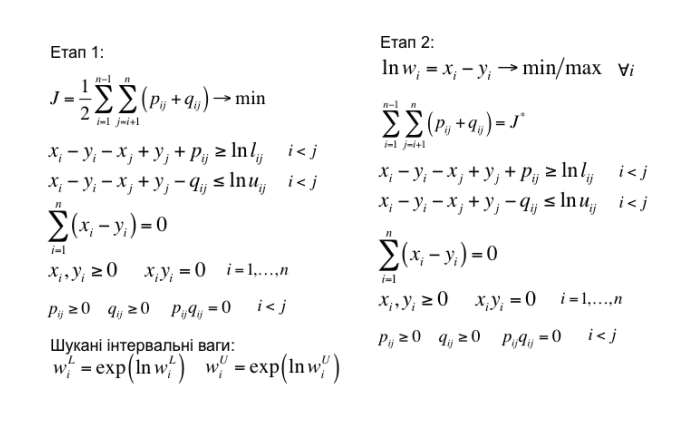

In [ ]:
def FPP(data_fuzzy, ds, verbose=False):
    
    n = data_fuzzy.shape[1]
    
    model = LpProblem("FPP", sense=LpMaximize)
    
    lam = LpVariable('lambda', lowBound=0, upBound=1)
    w = [LpVariable(f'w_{i + 1}', lowBound=0, upBound=1) for i in range(0, len(ds))]
    
    #[print(k, i, j) \
    #            for i in range(n) for j in range(n) for k in range(2) if i > j]
    
    lr_ineq = [ds.iloc[i, j] * lam + w[i] - data_fuzzy.iloc[i, j][1] * w[j] <= ds.iloc[i, j] if k == 0 \
                   else ds.iloc[i, j] * lam - w[i] + data_fuzzy.iloc[i, j][0] * w[j] <= ds.iloc[i, j] \
                   for i in range(n) for j in range(n) for k in range(2) if i < j]
    
    if verbose:
        for ineq in lr_ineq:
            print(f"subjected to {ineq};")
        
    constraint_sum = lpSum(w) == 1
    obj_func = lam
    
    for constraint in lr_ineq:
        model += constraint
        
    model += constraint_sum
    model += obj_func
    
    status = model.solve()
    
    summed = 0
    
    if verbose:  
        print(LpStatus[status])
        for var in w:
            print(f"{var.name}: {var.value()};")
            summed += var.value()
        print(f"optimal value {lam.value()}")

    w_fuzzy = pd.DataFrame([weight.value() for weight in w], index=data_fuzzy.index, columns=['weights'])
    CI = lam.value()
    print(f"CI={CI}")
    
    return w_fuzzy    